In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
data = pd.read_csv('../data/imdb.tsv', sep='\t')
X = data.review
y = data.sentiment
del data['id'] 
data.head()

,sentiment,review
0,1,With all this stuff going down at the moment w...
1,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,0,The film starts with a manager (Nicholas Bell)...
3,0,It must be assumed that those who praised this...
4,1,Superbly trashy and wondrously unpretentious 8...


In [3]:
data.sentiment.value_counts() 

1    12500
0    12500
Name: sentiment, dtype: int64

<b>1. (1 балл)</b> Разбейте выборку на train и test. Оставьте в test 4000 текстов. Для этого удобно воспользоваться <a href="http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html">train_test_split</a>

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size=4000, random_state=0, stratify=y)

<b>2. (2 балла)</b> Примените <a href="http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html">CountVectorizer</a>, чтобы превратить тексты в векторы чисел. <br>Вектор для текста имеет длину N, где N - количество различных слов в наших данных. Элемент вектора - число, определяющее, сколько раз слово i употреблялось в данном тексте.
Имеет смысл убрать стоп-слова. Это можно сделать параметром stop_words='english'

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english') 
vectorizer.fit(X_train) 
X_train_bag = vectorizer.transform(X_train)  
X_test_bag = vectorizer.transform(X_test) 

In [6]:
X_train_bag.shape

(21000, 69511)

<b>3. (2 балла)</b> Постройте Gradient Boosting, RF, Logistic Regression, KNN. Посчитайте score на тестовой выборке

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
classifiers = {'LGBMClassifier': 
                   XGBClassifier(random_state=42),
               'RandomForestClassifier': 
                   RandomForestClassifier(random_state=42),
               'LogisticRegression': 
                   LogisticRegression(random_state=42),
               'KNeighborsClassifier': 
                   KNeighborsClassifier()}

In [12]:
for name, clf in classifiers.items():
    %time clf.fit(X_train_bag, y_train)
    print(name, '\t', clf.score(X_test_bag, y_test))

CPU times: user 22.7 s, sys: 214 ms, total: 22.9 s
Wall time: 23.1 s
LGBMClassifier 	 0.7965


/Users/yellowduck/miniconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


CPU times: user 6.45 s, sys: 63.9 ms, total: 6.51 s
Wall time: 6.58 s
RandomForestClassifier 	 0.758
CPU times: user 3.04 s, sys: 44.5 ms, total: 3.09 s
Wall time: 3.11 s
LogisticRegression 	 0.8775
CPU times: user 7.09 ms, sys: 1.93 ms, total: 9.02 ms
Wall time: 8.55 ms
KNeighborsClassifier 	 0.59975


<b>4. (3 балла)</b> Выберете 1500 самых частых слов и создайте новые выборки из них

In [14]:
most_frequent = np.argsort(np.sum(X_train_bag.A, axis=0))[::-1][:1500]
X_train_frequent = X_train_bag[:, most_frequent] 
X_test_frequent = X_test_bag[:, most_frequent] 

<b>5. (1 балл)</b> Обучите Gradient Boosting, RF, Logistic Regression, KNN на новых выборках.

In [15]:
%%time
for name, clf in classifiers.items():
    clf.fit(X_train_frequent, y_train)
    print(name, '\t', clf.score(X_test_frequent, y_test))

/Users/yellowduck/miniconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


LGBMClassifier 	 0.7975
RandomForestClassifier 	 0.76275
LogisticRegression 	 0.84975
KNeighborsClassifier 	 0.60525
CPU times: user 19.6 s, sys: 1.19 s, total: 20.7 s
Wall time: 21 s


<b>6. (2 балла)</b> Посчитайте f1-меру ошибки каждого алгоритма. Для этого удобно воспользоваться <a href="http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">f1_score</a>

In [16]:
from sklearn.metrics import f1_score
for name, clf in classifiers.items():
    print(name, '\t', \
        f1_score(y_test.astype(float), clf.predict(X_test_frequent)))

LGBMClassifier 	 0.8111888111888113
RandomForestClassifier 	 0.7482090740249404
LogisticRegression 	 0.851127074560317


/Users/yellowduck/miniconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


KNeighborsClassifier 	 0.5832673528635524


<b>7. (3 балла)</b> Постройте *precision-recall* и *roc* кривые обученных выше классификаторов (каждый тип кривой на отдельном графике), а также вычислите площадь под ними. Для этого удобно воспользоваться функциями [precision_recall_curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html), [roc_curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) и [auc](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html#sklearn.metrics.auc). Не забудьте, что в данном случае необходимо использовать метод *predict_proba* для получения оценки принадлежности к первому классу.

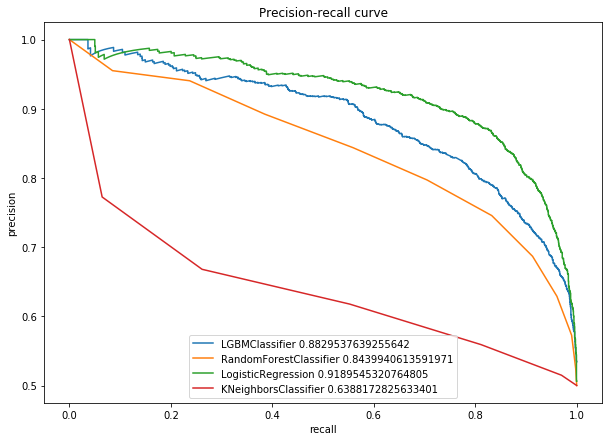

In [17]:
from sklearn.metrics import auc

plt.figure(figsize=(10,7))
from sklearn.metrics import precision_recall_curve
for name, clf in classifiers.items():
    
    precision, recall, thresh = \
        precision_recall_curve( 
            y_test, clf.predict_proba(X_test_frequent)[:,1])
        
    plt.plot(recall, precision, 
         label=name + ' ' + str(auc(recall, precision)))
    
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('Precision-recall curve')
plt.legend(loc='lower center');

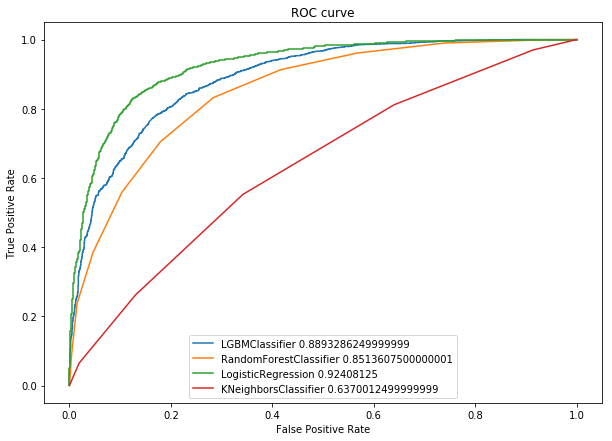

In [20]:
plt.figure(figsize=(10,7))
from sklearn.metrics import roc_curve
for name, clf in classifiers.items():
    fpr, trp, thresh = \
        roc_curve(y_test, clf.predict_proba(X_test_frequent)[:,1])
    plt.plot(fpr, trp, label=name + ' ' +  str(auc(fpr, trp)))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower center');

<b>8. (3 балла) </b>Воспользуйтесь <a href="http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html">TF-IDF кодированием</a>. Улучшился ли скор?

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_tf_idf = tf_idf_vectorizer.fit_transform(X_train)
X_test_tf_idf = tf_idf_vectorizer.transform(X_test)

In [24]:
X_train_tf_idf_f = X_train_tf_idf[:, most_frequent]
X_test_tf_idf_f = X_test_tf_idf[:, most_frequent] 

In [26]:
%%time
for name, clf in classifiers.items():
    clf.fit(X_train_tf_idf, y_train)
    print(name, '\t', clf.score(X_test_tf_idf, y_test))

/Users/yellowduck/miniconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


LGBMClassifier 	 0.8015
RandomForestClassifier 	 0.7545
LogisticRegression 	 0.8905
KNeighborsClassifier 	 0.78225
CPU times: user 45.1 s, sys: 1.52 s, total: 46.7 s
Wall time: 47.4 s


In [27]:
%%time
for name, clf in classifiers.items():
    clf.fit(X_train_tf_idf_f, y_train)
    print(name, '\t', clf.score(X_test_tf_idf_f, y_test))

/Users/yellowduck/miniconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


LGBMClassifier 	 0.80125
RandomForestClassifier 	 0.78
LogisticRegression 	 0.86275
KNeighborsClassifier 	 0.60325
CPU times: user 24 s, sys: 1.2 s, total: 25.2 s
Wall time: 25.5 s


<b>9. (4 балла)</b> Разбейте данные на 5 фолдов и подберите параметры у лучшего из алгоритмов. Улучшились ли AUC ROC, AUC PRC?

Попробуйте другие варианты выбора 1500 слов:

<b>10. (3 балла)</b> Постройте Gradient Boosting на всех словах (а не на 1500). С помощью feature\_importance\_ выберете 1500 слов, которые наиболее важны для классификации. Постройте все вышеуказанные алгоритмы на них. Улучшились ли результаты?

<b>11. (2 балла)</b> Постройте LogisticRegression с l1-нормализацией. Подберите параметр C таким образом, чтобы ненулевыми остались 1500 весов. Пересчитайте AUC ROC, AUC PRC